Please complete the `NotImplemented` parts of the code cells and write your answers in the markdown cells designated for your response to any questions asked. The tag `# AUTOGRADED` (all caps, with a space after `#`) should be at the beginning of each autograded code cell, so make sure that you do not change that. You are also not allowed to import any new package other than the ones already imported. Doing so will prevent the autograder from grading your code.

For the code submission, run the last cell in the notebook to create the submission zip file. If you are working in Colab, make sure to download and then upload a copy of the completed notebook itself to its working directory to be included in the zip file. Finally, submit the zip file to Gradescope.

If you are running the notebook locally, make sure you have created a virtual environment (using `conda` for example) and have the proper packages installed. We are working with `python=3.10` and `torch>=2`.

Files to be included in submission:

- `HW6.ipynb`
- `model_config.yaml`
- `train_config.yaml`
- `state_dict.pt`

In [5]:
"""
DO NOT ADD ANY ADDITIONAL IMPORTS IN THIS NOTEBOOK!
"""
from typing import Sequence, Dict, Union
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from HW6_utils import test_lstm_cell, save_yaml, load_yaml, zip_files

if torch.cuda.is_available():
    Device = 'cuda'
elif torch.backends.mps.is_available():
    Device = 'mps'
else:
    Device = 'cpu'

print(f'Device is {Device}')

Device is cpu


# Implement an LSTM cell in `numpy` (10)

Your first task in this assignment is to implement the calculations that happen inside an LSTMCell. Simply implement the following in code. $\odot$ is Hadamard product, which is just a fancy name for element-wise multiplication `*`.

$$
i = \sigma(W_{ii}x + b_{ii} + W_{hi}h + b_{hi})
$$
$$
f = \sigma(W_{if}x + b_{if} + W_{hf}h + b_{hf})
$$
$$
g = \tanh(W_{ig}x + b_{ig} + W_{hg}h + b_{hg})
$$
$$
o = \sigma(W_{io}x + b_{io} + W_{ho}h + b_{ho})
$$
$$
c' = f \odot c + i \odot g
$$
$$
h' = o \odot \tanh(c')
$$


In [6]:
# AUTOGRADED

"""
You are allowed to use only numpy in this cell.
"""

def sigmoid(x: np.ndarray) -> np.ndarray:
    # YOUR CODE
    return 1.0 / (1.0 + np.exp(-x))


def lstm_cell(
        x: np.ndarray, # new input of shape (batch_size, input_size)
        h_prev: np.ndarray, # previous hidden state of shape (batch_size, hidden_size)
        c_prev: np.ndarray, # previous cell state of shape (batch_size, hidden_size)
        params: Dict[str, np.ndarray], # dictionary containing the weights and biases
        ):
    
    """
    You can access each parameter by its name from the params dictionary.

    The names are weight_ba or bias_ba
    a is either i, f, g, o 
    b is either i, h
    
    example: params['weight_ii']

    For batched matrix multiplications, use x @ W or h @ W
    """
    # YOUR CODE
    # i = σ(W_{ii} x + b_{ii} + W_{hi} h + b_{hi})
    i = sigmoid(
        x @ params['weight_ii'] + params['bias_ii'] +
        h_prev @ params['weight_hi'] + params['bias_hi']
    )

    # f = σ(W_{if} x + b_{if} + W_{hf} h + b_{hf})
    f = sigmoid(
        x @ params['weight_if'] + params['bias_if'] +
        h_prev @ params['weight_hf'] + params['bias_hf']
    )

    # g = tanh(W_{ig} x + b_{ig} + W_{hg} h + b_{hg})
    g = np.tanh(
        x @ params['weight_ig'] + params['bias_ig'] +
        h_prev @ params['weight_hg'] + params['bias_hg']
    )

    # o = σ(W_{io} x + b_{io} + W_{ho} h + b_{ho})
    o = sigmoid(
        x @ params['weight_io'] + params['bias_io'] +
        h_prev @ params['weight_ho'] + params['bias_ho']
    )


    c = f * c_prev + i * g  # c' = f ⊙ c + i ⊙ g
    h = o * np.tanh(c)      # h' = o ⊙ tanh(c')
    
    return h, c


In [7]:
# Test your lstm_cell

test_lstm_cell(lstm_cell)

All tests passed!


# Implement and train an LSTM for fluid flow prediction (90)

You are going to implement a model that utilizes the LSTM mechanism to predict the evolution of a fluid flow over time, based on the parameters of the flow. 

Hagen-Poiseuille flow, first studied experimentally by G. Hagen in 1839 and J. L. Poiseuille in 1940, is the flow through a straight circular pipe. We assume that the flow is incompressible, pressure-driven, and one-dimensional along the axis of the pipe with a no-slip condition at the pipe walls. At steady-state, the velocity profile is a parabola. If we assume that the fluid is initially at rest and then set in motion by a pressure difference at the ends of the pipe, then there is a period of time where the velocity profiles are developing until they reach the final steady-state parabolic form. These developing velocity profiles can be represented as a time series. Below is the simplified form of Navier-Stokes for this time-dependent part of Hagen-Poiseuille flow. Here, $G$ represents the axial pressure gradient, $\rho$ is the fluid density, $\nu$ is the fluid viscosity, and $u$ represents the fluid velocity along the axis of the pipe. The solution is shown below the equation.

$$
\frac{\partial u}{\partial t} = \frac{G}{\rho} + \nu \left( \frac{\partial^2 u}{\partial r^2} + \frac{1}{r} \frac{\partial u}{\partial r} \right)
$$

$$
u(r, t) = \frac{G}{4\mu} \left( R^2 - r^2 \right) - \frac{2GR^2}{\mu} \sum_{n=1}^{\infty} \frac{J_0 \left( \lambda_n \frac{r}{R} \right)}{\lambda_n^3 J_1(\lambda_n)} \exp \left( - \lambda_n^2 \frac{\nu t}{R^2} \right)
$$

You are provided a dataset of 40500 training samples, where each sample consists of the flow parameters:

- $D = 2R$ the diameter of the pipe within the range $0.5 \leq D \leq 1$

- $G$ the pressure gradient within the range $-11 \leq G \leq -9$

- $\mu$ the dynamic viscosity within the range $0.7 \leq \mu \leq 0.9$

- $\nu=\dfrac{\mu}{\rho}$ the kinematic viscosity within the range $0.0008 \leq \nu \leq 0.001$

as well as the trajectory consisting of 20 time-steps, where each time-step is represented as the velocity values at a fixed number of grid points. The flow parameters are in `data/p_train.npy` and the trajectories are in `data/u_train.npy`. Your task is to define and train a Model that uses LSTM cells to model the temporal dynamics of the flow, as well as modules to encode the flow parameters to be used by the model.

The dataset class is provided for you. Use it to inspect the data. You can inspect the data, although the required information about the data to define your model is already provided for you.

In [8]:
class FlowDataset(Dataset):

    def __init__(
            self,
            p_path: str = 'data/p_train.npy',
            u_path: str = 'data/u_train.npy',
            ):
        super().__init__()
        p = np.load(p_path) # (n_samples, n_flow_params)
        u = np.load(u_path) # (n_samples, n_timesteps, n_points)

        self.p = torch.tensor(p, dtype=torch.float32)
        self.u = torch.tensor(u, dtype=torch.float32)

        # normalizing the magnitude of data
        self.p, self.u = self.normalize(self.p, self.u)

    @staticmethod
    def normalize(p, u):
        p_ = p / torch.tensor([1.0, -10.0, 1.0, 0.001], dtype=p.dtype, device=p.device)
        u_ = u / 0.1
        return p_, u_

    def __len__(self):
        return len(self.p)
    
    def __getitem__(self, idx):
        return self.p[idx], self.u[idx]

In [9]:
"""
Inspect the data.
You can also check the batched data with a toy dataloader.
"""

dataset = FlowDataset()
print("Number of samples in dataset:", len(dataset))

p_sample, u_sample = dataset[0]
print("Single sample shapes:")
print("  Flow parameters (p):", p_sample.shape)
print("  Flow trajectory (u):", u_sample.shape)

print("\nData types:")
print("  p dtype:", p_sample.dtype)
print("  u dtype:", u_sample.dtype)

print("\nSingle sample ranges:")
print("  p min, max:", p_sample.min().item(), p_sample.max().item())
print("  u min, max:", u_sample.min().item(), u_sample.max().item())

# Example of inspecting a small batch
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
p_batch, u_batch = next(iter(dataloader))
print("\nBatch shapes:")
print("  p_batch:", p_batch.shape)  # shape [batch_size, 4]
print("  u_batch:", u_batch.shape)  # shape [batch_size, 20, n_points]

print("\nBatch ranges:")
print("  p_batch min, max:", p_batch.min().item(), p_batch.max().item())
print("  u_batch min, max:", u_batch.min().item(), u_batch.max().item())

Number of samples in dataset: 40500
Single sample shapes:
  Flow parameters (p): torch.Size([4])
  Flow trajectory (u): torch.Size([20, 17])

Data types:
  p dtype: torch.float32
  u dtype: torch.float32

Single sample ranges:
  p min, max: 0.5 1.100000023841858
  u min, max: 0.004375104326754808 0.603384792804718

Batch shapes:
  p_batch: torch.Size([4, 4])
  u_batch: torch.Size([4, 20, 17])

Batch ranges:
  p_batch min, max: 0.5357142686843872 1.0571428537368774
  u_batch min, max: 0.004371722228825092 0.6662387251853943


## Implement a multi-layer LSTM (70)

Next, you should implement a multi-layer LSTM with flexible number of layers (stacked LSTM) and flexible hidden size per layer. The skeleton is already implemented, and your task is only to define the correct dimensions for the model components and the `forward` method. Each LSTM layer with index `i` consists of the following:

- A learnable encoder `h0-i` to calculate the initial hidden state ($h_0$) for that layer.

- A learnable encoder `c0-i` to calculate the initial cell state ($c_0$) for that layer.

- An LSTM cell `cell-i` with hidden size `hidden_sizes[i]`. Each of the stacked layers (`i>0`) takes the hidden state of the previous layer as their input.

Finally, the output layer is a Linear layer that takes the final layer's hidden state as input to calculate the model's prediction for that time-step.

The forward pass takes the following arguments as input:

- `p`: The flow parameters, which is used to calculate the initial hidden and cell state of the LSTM layers.

- `u`: The time series consisting of the flow data. Each time-step, the state of the system is represented wih the velocity values at a fixed number of grid points.

- `autoregressive`: Whether to use the model's perdiction or the ground truth for the inputs. For the first time-step, the ground truth is used anyway because the model has not made any predictions yet.

- `T`: number of time-steps to predict towards the future, starting from the initial time-step in `u`. If not specified, it is calculted based on the number of time-steps in `u`. If provided, only the first time-step of `u` is used.

Below you can see a simple illustration of the two options for the forward pass of the LSTM (our input is `u` though, not $x$). The first figure demonstrates teacher forcing, meaning that the ground truth is provided in every time-step. This is sometimes helpful to make training easier and more stable. The second figure shows the autoregressive option, which uses the model's prediction as the next input. You have to implement a multi-layer version of this. You can refer to the recitation for a figure on multi-layer RNNs.

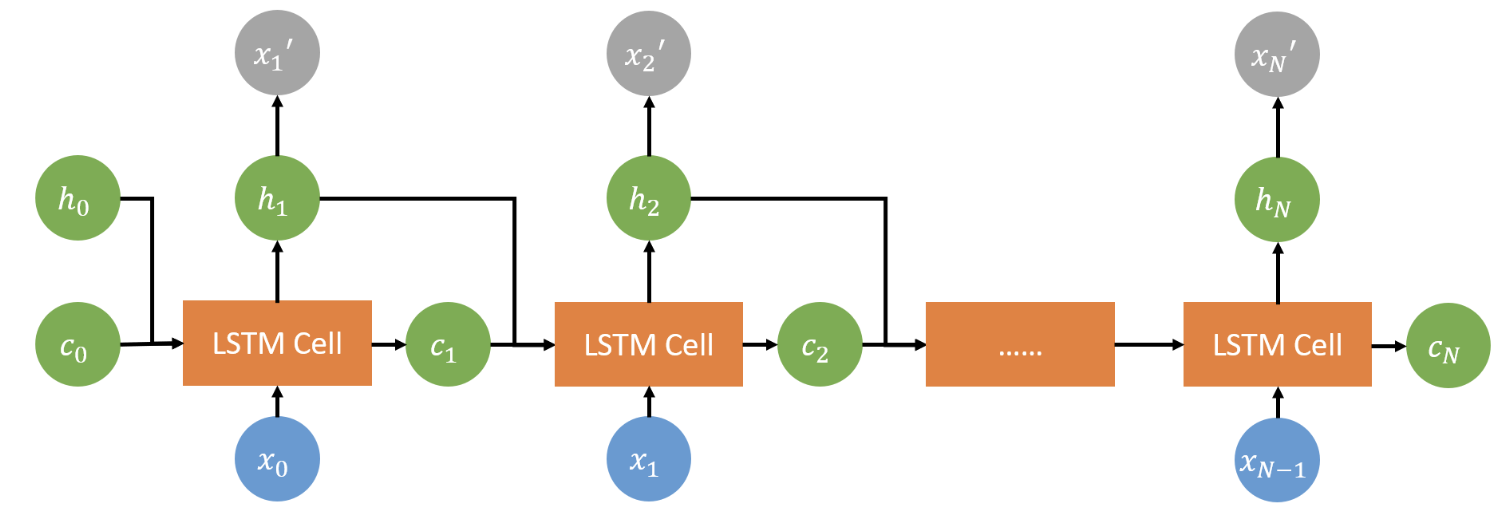

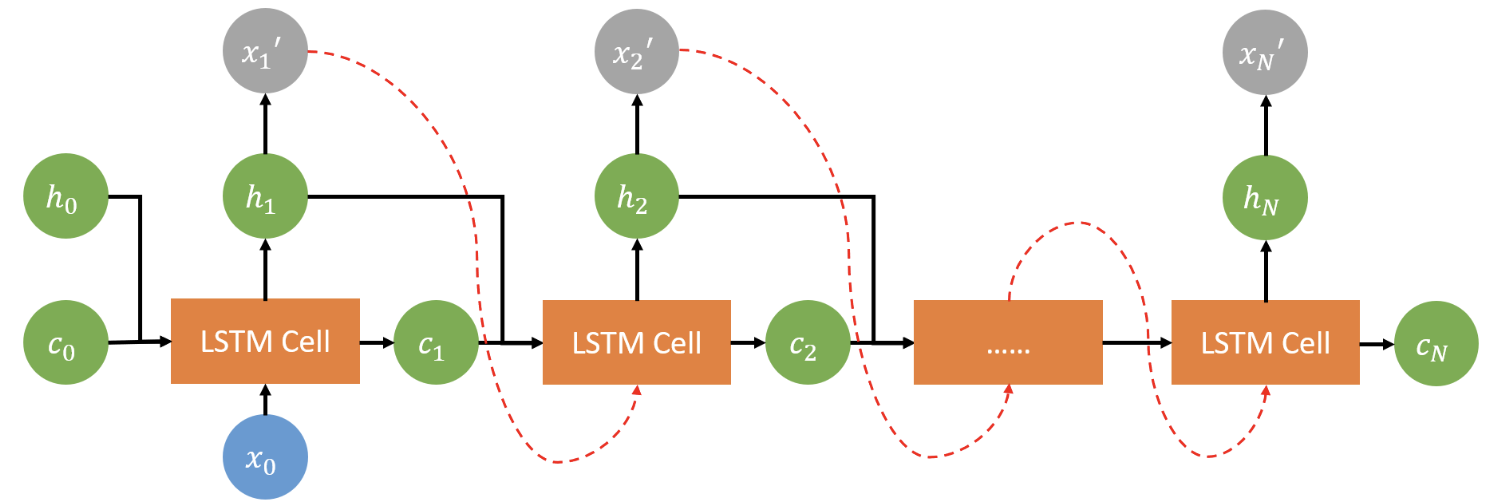

In [10]:
# AUTOGRADED

class FlowLSTM(nn.Module):
    '''
    Data inspection parameters should be added here in the init block
    as class variables example:

    Flow parameters is 4 and number of points is 17
    '''
    def __init__(
            self,
            hidden_sizes: Sequence[int] = [32, 64],
            ):
        super().__init__()

        assert len(hidden_sizes) > 0

        self.n_layers = len(hidden_sizes)
        self.model = nn.ModuleDict()
        self.points = 17
        self.flows = 4

        for i in range(self.n_layers):

            self.model[f'h0-{i}'] = nn.Linear(
                in_features = self.flows, 
                out_features = hidden_sizes[i],
                )
            
            self.model[f'c0-{i}'] = nn.Linear(
                in_features = self.flows, 
                out_features = hidden_sizes[i],
                )
            
            # Specify conditional input based on where in hidden layers
            self.model[f'cell-{i}'] = nn.LSTMCell(
                input_size = hidden_sizes[i-1] if i > 0 else self.points,
                hidden_size = hidden_sizes[i],
                )
            
        # Naturally the last hidden size is input
        self.out_layer = nn.Linear(
            in_features = hidden_sizes[-1],
            out_features = self.points,
            )

    def forward(
            self,
            p: torch.FloatTensor, # (batch_size, n_flow_params)
            u: torch.FloatTensor, # (batch_size, n_timesteps, n_points)
            autoregressive: bool = False,
            T: int = None, # number of time-steps to predict
            ) -> torch.FloatTensor: # (batch_size, n_timesteps, n_points)
        
        """
        The output is supposed to be the input shifted by one time-step.
        """
        
        # DO NOT CHANGE THIS IF-ELSE BLOCK
        if T is None:
            T = u.shape[1]
        else:
            assert isinstance(T, int) and T > 0, 'T should be a positive integer'

        batch_size, _, n_points = u.shape

        # Establish initial (h, c) for each layer by encoding p
        h = []
        c = []
        for i in range(self.n_layers):
            h_i = self.model[f'h0-{i}'](p)  # (batch_size, hidden_sizes[i])
            c_i = self.model[f'c0-{i}'](p)  # (batch_size, hidden_sizes[i])
            h.append(h_i)
            c.append(c_i)

        # Unroll the LSTM for T steps
        predictions = []

        for t in range(T):
            # Decide if using ground-truth or the model's last prediction
            if t == 0 or (not autoregressive):
                # On first step  use ground-truth
                x_t = u[:, t, :]  # shape: (batch_size, n_points)
            else:
                # Autoregressive mode: Use model's last prediction
                x_t = output_t  # from the final layer of the previous step

            # Pass through each LSTM layer
            for i in range(self.n_layers):
                h[i], c[i] = self.model[f'cell-{i}'](x_t, (h[i], c[i]))
                x_t = h[i]  # next layer gets h[i] as input

            # Produce output from last layer
            output_t = self.out_layer(x_t)  # shape: (batch_size, n_points)

            predictions.append(output_t.unsqueeze(1))  # (batch_size, 1, n_points)

        # predictions: list of length T, # (batch_size, T, n_points)
        return torch.cat(predictions, dim=1)  

## next step prediction loss calculation (10)

We want to train the model so that it predicts the next state at each time-step. Using a sampled batch `p` and `u`, fill in the function below to calculate the loss using the correct input, output, and target for the model and the loss function. You can assume that the  `reduction` of the loss function is `mean`, which means that the loss is averaged over samples and time-steps.

In [11]:
# AUTOGRADED

def next_step_prediction_loss(
        p: torch.FloatTensor, # (batch_size, n_flow_params)
        u: torch.FloatTensor, # (batch_size, n_timesteps, n_points)
        model: nn.Module,
        loss_fn: nn.Module = nn.MSELoss(),
        autoregressive: bool = False,
        ) -> torch.FloatTensor: # scalar with shape ()
    """
    Implement the loss for next-step prediction,
    using a sampled batch p and u.
    """
    # Forward pass: 
    predictions = model(p, u, autoregressive=autoregressive)
    
    # Compare model outputs for t with u at  t+1
    loss = loss_fn(predictions[:, :-1, :], u[:, 1:, :])
    
    return loss

## train and evaluate functions

In [13]:
@torch.enable_grad()
def train_epoch(
    model: nn.Module,
    data_loader: DataLoader,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    autoregressive: bool = False,
    device = Device,
    ):
    model.train().to(device)
    for p, u in data_loader:
        p, u = p.to(device), u.to(device)
        optimizer.zero_grad()
        loss = next_step_prediction_loss(
            p = p,  
            u = u,
            model = model, 
            loss_fn = loss_fn, 
            autoregressive = autoregressive,
            )
        loss.backward()
        optimizer.step()


@torch.inference_mode()
def eval_epoch(
    model: nn.Module,
    data_loader: DataLoader,
    loss_fn: nn.Module,
    autoregressive: bool = True,
    device = Device,
    ) -> float:
    assert loss_fn.reduction == 'mean'
    model.eval().to(device)
    Loss = 0.
    for p, u in data_loader:
        p, u = p.to(device), u.to(device)
        loss = next_step_prediction_loss(
            p = p,
            u = u,
            model = model, 
            loss_fn = loss_fn, 
            autoregressive = autoregressive,
            )
        Loss += loss*len(p)

    return Loss/len(data_loader.dataset)


def train(
        model: FlowLSTM,
        train_dataset: Dataset,
        loss_fn: nn.Module = nn.MSELoss(),
        device: str = Device,

        # New variables for sequence prediction
        autoregressive_training: bool = False,
        optimizer_name: str = 'Adam',
        optimizer_config: dict = dict(),
        lr_scheduler_name: Union[str, None] = None,
        lr_scheduler_config: dict = dict(),
        n_epochs: int = 1,
        batch_size: int = 1,
        ):
    
    model.to(device)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    optimizer = optim.__getattribute__(optimizer_name)(model.parameters(), **optimizer_config)
    if lr_scheduler_name is not None:
        scheduler: lr_scheduler.LRScheduler = lr_scheduler.__getattribute__(lr_scheduler_name)(optimizer, **lr_scheduler_config)

    epoch_pbar = tqdm(range(n_epochs), desc='Epochs', unit='epoch', leave=True)

    for epoch in epoch_pbar:

        train_epoch(
            model = model,
            data_loader = train_loader,
            loss_fn = loss_fn,
            optimizer = optimizer,
            autoregressive = autoregressive_training,
            device = device,
            )

        train_loss = eval_epoch(
            model = model,
            data_loader = train_loader,
            loss_fn = loss_fn,
            autoregressive = False,
            device = device,
            )

        train_loss_AR = eval_epoch(
            model = model,
            data_loader = train_loader,
            loss_fn = loss_fn,
            autoregressive = True,
            device = device,
            )

        if lr_scheduler_name == 'ReduceLROnPlateau':
            scheduler.step(train_loss)
        elif lr_scheduler_name is not None:
            scheduler.step()
        
        epoch_pbar.set_postfix_str(f'Loss: {train_loss:.8f}, Autoregressive Loss: {train_loss_AR:.8f}')

## Find and train a good model (10)

As usual, you have to find a good model (good hyperparameters) and train it to get acceptable loss. Your model will be evaluated on a test dataset and your final grade depends on the autoregressive test loss.

- $\text{test MSE} < 10^{-6}$: 15 points (5 bonus)

- $10^{-6} \leq \text{test MSE} < 10^{-5}$: 10 points

- $10^{-5} \leq \text{test MSE} < 10^{-4}$: 5 points

- $\text{test MSE} \geq 10^{-4}$: 0 points


In [ ]:
model_config = dict(
    hidden_sizes = [32, 64],
)

train_config = dict(
    autoregressive_training = True,
    optimizer_name = 'Adam',
    optimizer_config = dict(lr=1e-3),
    lr_scheduler_name = 'ReduceLROnPlateau',
    lr_scheduler_config = dict(factor=0.5, patience=2),
    n_epochs = 10,
    batch_size = 32,
)

'''
Found a new LR scheduler to try after searching for specific schedulers
to use on engineering problems like these. I've only used StepLR and ExponentialLR
so trying this out. I like the concept of this, and would have probably used it before
now if I'd found it earlier.

Base: Hidden Sizes = [32,64] like default
    autoregressive_training = False,
    optimizer_name = 'Adam',
    optimizer_config = dict(lr=1e-3),
    lr_scheduler_name = 'ReduceLROnPlateau',
    lr_scheduler_config = dict(factor=0.5, patience=2),
    n_epochs = 10,
    batch_size = 64,

1 Epoch: 2.3e-4
ReduceLROnPlateau:
5: 2.3e-5
10: 3.2e-5
Autoregressive True: 2.8e-6
Batch Size 32:   1.14e-6    reached nearly previous best in only 3 epochs

Obviously autoregressive helped a ton. Trying normal StepLR for comparison
    lr_scheduler_config = dict(step_size=10, gamma=0.1),
    n_epochs = 10,
    batch_size = 64,
StepLR: 5e-6

'''

if __name__ == '__main__':
    flow_dataset = FlowDataset()
    model = FlowLSTM(**model_config)
    train(
        model = model, 
        train_dataset = flow_dataset, 
        device = Device, 
        **train_config,
    )

Epochs: 100%|██████████| 10/10 [06:02<00:00, 36.26s/epoch, Loss: 0.00000115, Autoregressive Loss: 0.00000114]


# Zip submission files

You can run the following cell to zip the generated files for submission.

If you are on Colab, make sure to download and then upload a completed copy of the notebook to the working directory so the code can detect and include it in the zip file for submission.

In [23]:
save_yaml(model_config, 'model_config.yaml')
save_yaml(train_config, 'train_config.yaml')
torch.save(model.cpu().state_dict(), 'state_dict.pt')

# test if the model can be loaded successfully
loaded_model = FlowLSTM(**load_yaml('model_config.yaml')).cpu()
loaded_model.load_state_dict(torch.load('state_dict.pt', map_location='cpu'))
print('Model loaded successfully!')

submission_files = ['HW6.ipynb', 'model_config.yaml', 'train_config.yaml', 'state_dict.pt']
zip_files('HW6_submission.zip', submission_files)

Model loaded successfully!


/tmp/ipykernel_148421/3185366518.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('state_dict.pt', map_location='cpu'))


# Optional: Visualize the model's output

You are provided with a cool flow visualizer here. You can visualize a sample from the dataset and compare it to the model's output, and also predict the flow for any arbitrary set of flow parameters. Enjoy!

In [24]:
import os
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.autolayout': True})
import ipywidgets as widgets
from IPython.display import display, clear_output
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except ImportError:
    pass
try:
    %matplotlib widget
except:
    os.system('pip install ipympl -qq')
    %matplotlib widget


class FlowViz:

    def __init__(
            self,
            dataset: Dataset,
            model: nn.Module,
            ):
        self.dataset = dataset
        self.model = model.eval().cpu()
    
    @torch.inference_mode()
    def viz_sample(
            self,
            idx: int,
            ):
        
        plt.close()
        p, u = self.dataset[idx]
        D = p[0].numpy()

        pred = self.model(p[None, ...], u[None, :-1, ...], autoregressive=True)[0]
        true = u[1:]
        fig, (ax_true, ax_pred) = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
        for t in range(19):
            ax_true.plot(
                np.linspace(-D/2, D/2, 17),
                true[t].numpy(),
                label = f't={t+1}',
                c = (t/19, 0.2, 1-t/19)
            )
            ax_pred.plot(
                np.linspace(-D/2, D/2, 17),
                pred[t].numpy(),
                label = f't={t+1}',
                c = (t/19, 0.2, 1-t/19)
            )
        ax_true.set_title('True')
        ax_true.set_xlabel('r')
        ax_true.set_ylabel('u')
        ax_true.grid(linestyle='--')
        ax_pred.set_title('Predicted')
        ax_pred.set_xlabel('r')
        ax_pred.set_ylabel('u')
        ax_pred.grid(linestyle='--')
        plt.legend(loc=(1.02, 0))
        plt.show()

    @torch.inference_mode()
    def viz_flow(self, D, G, mu, nu):
        # X contains the flow parameters
        T = self.T
        p = torch.tensor([D, G, mu, nu], dtype=torch.float32, device='cpu')
        u = torch.zeros(1, 17)
        p, u = self.dataset.normalize(p, u)
        pred = self.model(p[None, ...], u[None, ...], autoregressive=True, T=T)[0]

        for t in range(self.T):
            self.lines[t].set_xdata(np.linspace(-D/2, D/2, 17))
            self.lines[t].set_ydata(pred[t].numpy())

        self.fig.canvas.draw()

    def run_viz_flow(self, T=20):

        self.T = T

        self.D = widgets.FloatSlider(
            value=0.75,
            min=0.5,
            max=1.0,
            step=0.01,
            description='D',
            continuous_update=True,
            )
        self.G = widgets.FloatSlider(
            value=-10.0,
            min=-11.0,
            max=-9.0,
            step=0.01,
            description='G',
            continuous_update=True,
            )
        self.mu = widgets.FloatSlider(
            value=0.8,
            min=0.7,
            max=0.9,
            step=0.01,
            description='mu',
            continuous_update=True,
            )
        self.nu = widgets.FloatSlider(
            value=0.0009,
            min=0.0008,
            max=0.001,
            step=0.00001,
            description='nu',
            continuous_update=True,
            readout_format='.5f',
            )
        
        plt.close()
        self.fig, self.ax = plt.subplots(figsize=(5, 5))
        self.lines = {}
        for t in range(T):
            self.lines[t], = self.ax.plot(
                np.linspace(-1/2, 1/2, 17),
                np.zeros(17),
                label = f't={t+1}',
                c = (t/T, 0.2, 1-t/T)
            )
        self.ax.set_xlabel('r')
        self.ax.set_ylabel('u')
        self.ax.set_ylim([0, 1])
        self.ax.grid(linestyle='--')
        self.ax.legend(loc=(1.02, 0))

        widgets.interact(
            self.viz_flow,
            D = self.D,
            G = self.G,
            mu = self.mu,
            nu = self.nu,
            )
        
        clear_output(wait=True)
        display(self.D, self.G, self.mu, self.nu)

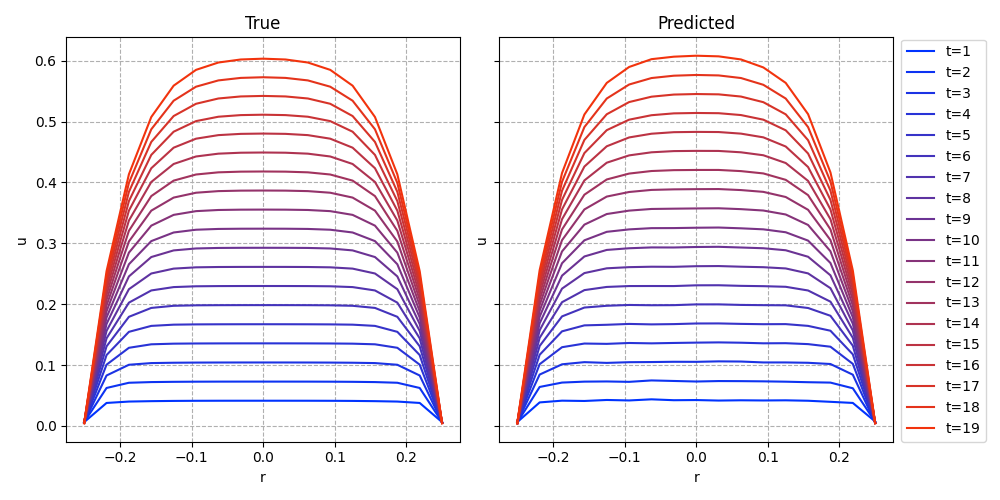

In [25]:
"""
visualize an arbitrary sample from the dataset and compare it to the model's autoregressive prediction
"""
if __name__ == '__main__':
    flow_viz = FlowViz(flow_dataset, model)
    flow_viz.viz_sample(idx = 0)

FloatSlider(value=0.75, description='D', max=1.0, min=0.5, step=0.01)

FloatSlider(value=-10.0, description='G', max=-9.0, min=-11.0, step=0.01)

FloatSlider(value=0.8, description='mu', max=0.9, min=0.7, step=0.01)

FloatSlider(value=0.0009, description='nu', max=0.001, min=0.0008, readout_format='.5f', step=1e-05)

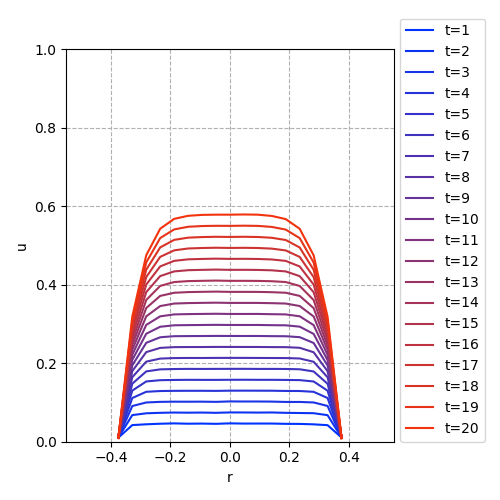

In [26]:
"""
Visualize the flow for arbitrary flow parameters amd number of time-steps.
You can see the effect of the flow parameter.
"""
if __name__ == '__main__':
    flow_viz = FlowViz(flow_dataset, model)
    flow_viz.run_viz_flow(T = 20)